<a href="https://colab.research.google.com/github/bipinKrishnan/tensorflow_to_pytorch/blob/master/CNN_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.datasets.utils import download_and_extract_archive

import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

## Get the data

In [2]:
#download cats and dogs dataset from url

url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
file_name = 'cats_and_dogs'
download_and_extract_archive(url, file_name)

Extracting cats_and_dogs/cats_and_dogs_filtered.zip to cats_and_dogs


In [3]:
base_path = 'cats_and_dogs/cats_and_dogs_filtered'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'validation')

train_cats = os.path.join(train_path, 'cats')
test_cats = os.path.join(test_path, 'cats')

train_dogs = os.path.join(train_path, 'dogs')
test_dogs = os.path.join(test_path, 'dogs')

In [4]:
#print number of cat and dog images in 
#training & validation set

print('Training cat images: ', len(os.listdir(train_cats)))
print('Training dog images: ', len(os.listdir(train_dogs)))
print('-----')
print('Validation cat images: ', len(os.listdir(test_cats)))
print('Validation dog images: ', len(os.listdir(test_dogs)))

Training cat images:  1000
Training dog images:  1000
-----
Validation cat images:  500
Validation dog images:  500


## Load data in the required form

In [5]:
bs = 128
epochs = 15
img_h = 200
img_w = 200

In [6]:
def load_dataset(root_path, shuffle=False):
  train_images = ImageFolder(
      root=root_path,
      transform=transforms.Compose([
                                    transforms.Resize((img_w, img_h)), 
                                    transforms.ToTensor()
                                    ])
  ) 

  data_loader = DataLoader(
      train_images,
      batch_size=bs,
      shuffle=shuffle
  )

  return data_loader                           

In [7]:
train_loader = load_dataset(train_path, shuffle=True)
test_loader = load_dataset(test_path, shuffle=False)

In [8]:
for i, (img, lab) in enumerate(train_loader):
  if i < 3:
    print(img.shape)
  else:
    break

torch.Size([128, 3, 200, 200])
torch.Size([128, 3, 200, 200])
torch.Size([128, 3, 200, 200])


In [9]:
def display_images(dataloader):
  target = ['cat', 'dog']
  
  for i, (img, lab) in enumerate(dataloader):
    if i < 8:
      np_img = img[0].numpy()
      np_img = np.transpose(np_img, (1, 2, 0))
      plt.subplot(2, 4, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(target[int(lab[0])])
      plt.imshow(np_img)
    else:
      break 

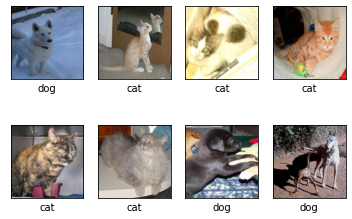

In [10]:
display_images(train_loader)

## Create model

In [11]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.c1 = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fcn = nn.Sequential(
        nn.Linear(40000, 512),
        nn.ReLU(),
        nn.Linear(512, 1)
    )

  def forward(self, inputs):
    conv = self.c1(inputs)
    flatten_img = conv.view(conv.size(0), -1)
    out = self.fcn(flatten_img)
    
    return out

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN()
model = model.to(device)

In [13]:
#model summary
print(model)

CNN(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcn): Sequential(
    (0): Linear(in_features=40000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


# Train the model

In [14]:
criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(model.parameters())

In [23]:
def evaluation(dataloader):
  total, correct = 0, 0

  for i, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)

    out = model(images)
    _, pred = torch.max(out.data, 1)

    opt.step()

    total += labels.size(0)
    correct += (pred==labels).sum().item()

    return (correct / total)* 100

In [ ]:
for epoch in range(epochs):
  for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
    images, labels = images.to(device), labels.to(device)
    
    opt.zero_grad()

    out = model(images)
    
    #covert labels variable to float for calcualting loss
    loss = criterion(out, torch.unsqueeze(labels/1.0, 1))
    loss.backward()

    opt.step()

  print('Epoch: {0}/{1} \t acc: {2} \t loss: {3} \t val_acc: {4}'.format(epoch+1, epochs, round(evaluation(train_loader), 4), round(loss.item(), 4), round(evaluation(test_loader), 4)))




Epoch: 1/15 	 acc: 55.4688 	 loss: 0.6755 	 val_acc: 100.0



Epoch: 2/15 	 acc: 53.125 	 loss: 0.7135 	 val_acc: 100.0



Epoch: 3/15 	 acc: 46.0938 	 loss: 0.6648 	 val_acc: 100.0



Epoch: 4/15 	 acc: 50.7812 	 loss: 0.6269 	 val_acc: 100.0



Epoch: 5/15 	 acc: 48.4375 	 loss: 0.6166 	 val_acc: 100.0



Epoch: 6/15 	 acc: 53.125 	 loss: 0.639 	 val_acc: 100.0



Epoch: 7/15 	 acc: 49.2188 	 loss: 0.654 	 val_acc: 100.0



Epoch: 8/15 	 acc: 52.3438 	 loss: 0.6254 	 val_acc: 100.0



Epoch: 9/15 	 acc: 54.6875 	 loss: 0.6586 	 val_acc: 100.0



Epoch: 10/15 	 acc: 51.5625 	 loss: 0.63 	 val_acc: 100.0



Epoch: 11/15 	 acc: 47.6562 	 loss: 0.6196 	 val_acc: 100.0



Epoch: 12/15 	 acc: 48.4375 	 loss: 0.5789 	 val_acc: 100.0



Epoch: 13/15 	 acc: 54.6875 	 loss: 0.4748 	 val_acc: 100.0



Epoch: 14/15 	 acc: 40.625 	 loss: 0.5765 	 val_acc: 100.0



Epoch: 15/15 	 acc: 46.875 	 loss: 0.5857 	 val_acc: 100.0
